In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data import funcs
from BioPlexPy.data_import_funcs import getBioPlex
from BioPlexPy.data_import_funcs import getCorum

# analysis funcs
from BioPlexPy.analysis_funcs import bioplex2graph

## [0] Environment Setup

setup for running 
- created virtual environment in conda 
> conda create -n CCB_BioPlexPy python=3.7
- installed **pandas**
> conda install -c anaconda pandas
- installed **requests**
> conda install -c anaconda requests
- installed **anndata**
> conda install anndata -c bioconda
- installed **jupyter notebook**
> conda install -c conda-forge notebook
- installed **networkx**
> pip install networkx[default]
- installed **biopython**
> conda install -c conda-forge biopython

## [1] *Function* to visualize PPI data for a given complex from CORUM

check to see inconsistancies between *Uniprot > Symbol* for BioPlex PPI dataset and CORUM complex sets

### Uniprot -> Symbol mapping from BioPlex data

In [5]:
bp_PPI_df = getBioPlex('293T', '3.0')
bp_PPI_df.head()

,GeneA,GeneB,UniprotA,UniprotB,SymbolA,SymbolB,pW,pNI,pInt
0,100,728378,P00813,A5A3E0,ADA,POTEF,6.881844e-10,0.000118,0.999882
1,222389,6137,Q8N7W2-2,P26373,BEND7,RPL13,1.340380e-18,0.225664,0.774336
2,222389,5928,Q8N7W2-2,Q09028-3,BEND7,RBBP4,7.221401e-21,0.000064,0.999936
3,222389,25873,Q8N7W2-2,Q9Y3U8,BEND7,RPL36,7.058372e-17,0.128183,0.871817
4,222389,6124,Q8N7W2-2,P36578,BEND7,RPL4,1.632313e-22,0.200638,0.799362


In [6]:
# create mapping of UniProt IDs to Gene Symbols from PPI data
# reconstruct UniprotA/UniprotB columns without '-' isoform id
UniprotA_new = []
UniprotB_new = []
for UniprotA, UniprotB in zip(bp_PPI_df.UniprotA, bp_PPI_df.UniprotB):

    if '-' in UniprotA:
        UniprotA_new.append(UniprotA.split('-')[0])
    else:
        UniprotA_new.append(UniprotA)

    if '-' in UniprotB:
        UniprotB_new.append(UniprotB.split('-')[0])
    else:
        UniprotB_new.append(UniprotB)

# update columns for Uniprot source & Uniprot target to exclude isoform '-' ID
bp_PPI_df.loc[:,'UniprotA'] = UniprotA_new
bp_PPI_df.loc[:,'UniprotB'] = UniprotB_new

# get mapping uniprot -> symbol & store as node attribute
uniprot_symbol_dict_PPI = {}
for uniprot_A, symbol_A in zip(bp_PPI_df.UniprotA, bp_PPI_df.SymbolA):
    uniprot_symbol_dict_PPI[uniprot_A] = symbol_A
for uniprot_B, symbol_B in zip(bp_PPI_df.UniprotB, bp_PPI_df.SymbolB):
    uniprot_symbol_dict_PPI[uniprot_B] = symbol_B

In [7]:
len(uniprot_symbol_dict_PPI.keys())

13689

### Uniprot -> Symbol mapping from CORUM data

In [8]:
Corum_DF = getCorum('core', 'Human')
Corum_DF.head()

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
0,1,BCL6-HDAC4 complex,Human,None,None,P41182;P56524,604;9759,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC4,11929873,B-cell lymphoma 6 protein;Histone deacetylase 4
1,2,BCL6-HDAC5 complex,Human,None,None,P41182;Q9UQL6,604;10014,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC5,11929873,B-cell lymphoma 6 protein;Histone deacetylase 5
2,3,BCL6-HDAC7 complex,Human,None,None,P41182;Q8WUI4,604;51564,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL5 LAZ3 ZBTB27 ZNF51;HDAC7A,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),None,BCL6;HDAC7,11929873,B-cell lymphoma 6 protein;Histone deacetylase 7
3,4,Multisubunit ACTR coactivator complex,Human,None,None,Q09472;Q92793;Q92831;Q9Y6Q9,2033;1387;8850;8202,MI:0004-affinity chromatography technologies;M...,GO:0045893;GO:0023052;GO:0005634,"positive regulation of transcription, DNA-temp...",11.02.03.04.01;30.01;70.10,transcription activation;cellular signalling;n...,"P300;CBP;PCAF;AIB1, BHLHE42, RAC3, TRAM1, ACTR",Cofactor ACTR binds directly nuclear receptors...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,EP300;CREBBP;KAT2B;NCOA3,9267036,Histone acetyltransferase p300;CREB-binding pr...
4,11,BLOC-3 (biogenesis of lysosome-related organel...,Human,None,None,Q92902;Q9NQG7,3257;89781,MI:0019- coimmunoprecipitation; MI:0029- cosed...,GO:0007032;GO:0007040;GO:0007033,endosome organization;lysosome organization;va...,42.22;42.25,endosome;vacuole or lysosome,HPS;KIAA1667,The results suggest that HPS1 and HPS4 are com...,HPS1-7 are involved in Hermansky-Pudlak syndro...,Homo sapiens (Human);Homo sapiens (Human),None,HPS1;HPS4,12847290,Hermansky-Pudlak syndrome 1 protein;Hermansky-...


In [9]:
# create mapping of UniProt IDs to Gene Symbols from CORUM data
uniprot_symbol_dict_entry_list = [] # list of lists
for Complex_ID in Corum_DF.ComplexID:
    
    genes_in_complex_i = Corum_DF[Corum_DF.ComplexID == Complex_ID].loc[:,'subunits(UniProt IDs)'].values[0].split(';')
    gene_symbols_in_complex_i = Corum_DF[Corum_DF.ComplexID == Complex_ID].loc[:,'subunits(Gene name)'].values[0].split(';')
    
    # get mapping uniprot -> symbol & store as node attribute from CORUM complex data
    uniprot_symbol_dict_entry_i = [[key,val] for key, val in zip(genes_in_complex_i, gene_symbols_in_complex_i)]
    uniprot_symbol_dict_entry_list.append(uniprot_symbol_dict_entry_i)

# unroll list of lists
uniprot_symbol_dict_entry_list = [item for sublist in uniprot_symbol_dict_entry_list for item in sublist]
uniprot_symbol_dict_CORUM = dict(uniprot_symbol_dict_entry_list)

In [10]:
len(uniprot_symbol_dict_CORUM.keys())

3449

### Compare mappings for Uniprot IDs that have gene symbols in both *BioPlex* and *CORUM* data

In [12]:
import pandas as pd

In [13]:
all_uniprot_ids = list(set(list(uniprot_symbol_dict_PPI.keys()) + list(uniprot_symbol_dict_CORUM.keys())))
PPI_symbol = []
CORUM_symbol = []
uniprot_ids_list = []
for uniprot_ID in all_uniprot_ids:
    
    if (uniprot_ID in uniprot_symbol_dict_PPI.keys()) and (uniprot_ID in uniprot_symbol_dict_CORUM.keys()):
        PPI_symbol.append(uniprot_symbol_dict_PPI[uniprot_ID])
        CORUM_symbol.append(uniprot_symbol_dict_CORUM[uniprot_ID])
        uniprot_ids_list.append(uniprot_ID)
        
Uniprot_to_Symbol_map_DF = pd.DataFrame(index = uniprot_ids_list)
Uniprot_to_Symbol_map_DF[['BioPlex']] = PPI_symbol
Uniprot_to_Symbol_map_DF[['CORUM']] = CORUM_symbol

In [14]:
Uniprot_to_Symbol_map_DF.head()

,BioPlex,CORUM
Q6NUQ1,RINT1,RINT1
Q9UKT8,FBXW2,FBXW2
O14657,TOR1B,TOR1B
P25054,APC,APC
P60484,PTEN,PTEN


In [15]:
Uniprot_to_Symbol_map_DF.shape

(3058, 2)

In [16]:
sum(Uniprot_to_Symbol_map_DF.BioPlex == Uniprot_to_Symbol_map_DF.CORUM)

2839

In [17]:
sum(Uniprot_to_Symbol_map_DF.BioPlex != Uniprot_to_Symbol_map_DF.CORUM)

219

In [18]:
Uniprot_to_Symbol_map_DF[Uniprot_to_Symbol_map_DF.BioPlex != Uniprot_to_Symbol_map_DF.CORUM].head(n=25)

,BioPlex,CORUM
Q9Y448,C15orf23,KNSTRN
Q9NWR8,CCDC109B,MCUB
P62269,RPS18,RPS23
Q14687,KIAA0182,GSE1
Q9Y5B9,SUPT16H,CENPH
Q16637,SMN2,SMN1
Q9NQC1,PHF15,JADE2
P62987,UBA52,RPL41
Q08495,EPB49,DMTN
P18615,RDBP,NELFE


minor problem when using **uniprots** and not **gene symbols** for visualization functions
- if you have genes in a complex that *are not* picked up in PPI data then you won't have a **uniprot ID** to **gene symbol** mapping which will prevent you from labeling the network with **gene symbols** at the end
example: 

- **Q4LE39-2** > **ARID4B** in the BioPlex 293T 3.0 data

- **A0A024R3R1** > **ARID4B** in the CORUM core human data

**we are going to use UNIPROT IDs to map between BioPlex data and CORUM complexes**

In [19]:
import numpy as np
import itertools
import networkx as nx

def display_PPI_network_for_complex(ax, bp_PPI_df, Corum_DF, Complex_ID, node_size, edge_width, node_font_size = 10, bait_node_color='xkcd:red', prey_node_color='xkcd:rose pink', AP_MS_edge_color='xkcd:red', node_pos=False):
    '''
    Display network of BioPlex PPIs for a CORUM complex.
    
    This function displays a complete network in which nodes represent 
    the proteins in a specified CORUM complex and edges represent 
    BioPlex PPIs using NetworkX. Edges detected through AP-MS are colored darker.

    Parameters
    ----------
    ax object to draw on: Matplotlib Axes
    DataFrame of PPIs : Pandas DataFrame
    DataFrame of CORUM complexes : Pandas DataFrame
    Corum Complex ID: int
    Size of Nodes in Network: int
    Width of Edges in Network: float
    Size of font for Node Labels: int (optional)
    Color of Nodes targeted as baits: str (optional)
    Color of Nodes detected as preys only: str (optional)
    Color of Edges observed via AP-MS from PPI data: str (optional)
    Networkx Position of Nodes: dict (optional)

    Returns
    -------
    Node Positions
        Dictionary of Node Positions in NetworkX layout

    Examples
    --------
    >>> bp_PPI_df = getBioPlex('293T', '3.0') # (1) Obtain the latest version of the 293T PPI network
    >>> Corum_DF = getCorum('core', 'Human') # (2) Obtain CORUM complexes
    >>> fig, ax = plt.subplots() # (3) create figure and axis objects to draw on
    >>> ING2_node_layout = display_PPI_network_for_complex(ax, bp_PPI_df, Corum_DF, 2851, 2300, 3.5) # (4) Visualize network for specified protein complex using PPI data (ING2 complex ID: 2851)
    '''
    # store uniprot IDs & gene symbols that belong to this complex in a list
    genes_in_complex_i = Corum_DF[Corum_DF.ComplexID == Complex_ID].loc[:,'subunits(UniProt IDs)'].values[0].split(';') # Uniprot
    gene_symbols_in_complex_i = Corum_DF[Corum_DF.ComplexID == Complex_ID].loc[:,'subunits(Gene name)'].values[0].split(';') # Symbol

    # filter BioPlex PPI dataframe to include only interactions where both genes are found in complex
    complex_i_PPI_filter = []
    for uniprot_A, uniprot_B in zip(bp_PPI_df.UniprotA, bp_PPI_df.UniprotB):
        
        # check for isoform IDs and adjust
        if '-' in uniprot_A:
            uniprot_A = uniprot_A.split('-')[0]
        if '-' in uniprot_B:
            uniprot_B = uniprot_B.split('-')[0]

        # check to see if both gene symbols for this interaction are genes in complex
        if (uniprot_A in genes_in_complex_i) and (uniprot_B in genes_in_complex_i):
            complex_i_PPI_filter.append(True)
        else:
            complex_i_PPI_filter.append(False)

    complex_i_PPI_filter = np.array(complex_i_PPI_filter)
    bp_complex_i_df = bp_PPI_df[complex_i_PPI_filter] # use filter to subset bp PPI dataframe
    bp_complex_i_df.reset_index(inplace = True, drop = True) # reset index

    # reconstruct UniprotA/UniprotB columns without '-' isoform id
    UniprotA_new = []
    UniprotB_new = []
    for UniprotA, UniprotB in zip(bp_complex_i_df.UniprotA, bp_complex_i_df.UniprotB):

        if '-' in UniprotA:
            UniprotA_new.append(UniprotA.split('-')[0])
        else:
            UniprotA_new.append(UniprotA)

        if '-' in UniprotB:
            UniprotB_new.append(UniprotB.split('-')[0])
        else:
            UniprotB_new.append(UniprotB)
            
    # update columns for Uniprot source & Uniprot target to exclude isoform '-' ID
    bp_complex_i_df.loc[:,'UniprotA'] = UniprotA_new
    bp_complex_i_df.loc[:,'UniprotB'] = UniprotB_new
    
    # subset PPI dataframe to the cols we need to construct graph
    bp_complex_i_df = bp_complex_i_df.loc[:,['UniprotA','UniprotB','SymbolA','SymbolB']]
    
    # create a graph from the nodes/genes of specified complex
    bp_complex_i_G = nx.Graph()
    bp_complex_i_G.add_nodes_from(genes_in_complex_i)
    
    # iterate over AP-MS interactions in PPI df and add edges
    for source, target in zip(bp_complex_i_df.UniprotA, bp_complex_i_df.UniprotB):
        bp_complex_i_G.add_edge(source, target)
        
    # get mapping uniprot -> symbol & store as node attribute from CORUM complex data
    uniprot_symbol_dict = dict([key,val] for key, val in zip(genes_in_complex_i, gene_symbols_in_complex_i))
    for node_i in bp_complex_i_G.nodes():
        bp_complex_i_G.nodes[node_i]["symbol"] = uniprot_symbol_dict[node_i]

    # get a list of genes that were identifed as "baits" and "preys" for coloring nodes
    bp_complex_i_baits = list(set(bp_complex_i_df.UniprotA))
    bp_complex_i_preys = list(set(bp_complex_i_df.UniprotB))

    labels = dict([(key,val) for key, val in zip(list(bp_complex_i_G.nodes), [bp_complex_i_G.nodes[node_i]['symbol'] for node_i in bp_complex_i_G.nodes])])

    # color nodes according to whether they were present among "baits" & "preys", just "baits", just "preys" or not detected in PPI data for this complex
    node_color_map = []
    for node_i_uniprot in bp_complex_i_G.nodes:

        # gene is present among baits & preys for the PPIs detected in this complex
        if (node_i_uniprot in bp_complex_i_baits) and (node_i_uniprot in bp_complex_i_preys):
            node_color_map.append(bait_node_color)

        # gene is present among baits but NOT preys for the PPIs detected in this complex
        elif (node_i_uniprot in bp_complex_i_baits) and (node_i_uniprot not in bp_complex_i_preys):
            node_color_map.append(bait_node_color)

        # gene is NOT present among baits but is present among preys for the PPIs detected in this complex
        elif (node_i_uniprot not in bp_complex_i_baits) and (node_i_uniprot in bp_complex_i_preys):
            node_color_map.append(prey_node_color)

        # gene is NOT present among baits and is NOT present among preys for the PPIs detected in this complex
        elif (node_i_uniprot not in bp_complex_i_baits) and (node_i_uniprot not in bp_complex_i_preys):
            node_color_map.append('0.7')

    # create a complete graph from the nodes of complex graph to add in all "background" edges (edges detected with AP-MS will be colored over)
    # position will be the same for both graphs since nodes are the same
    bp_complex_i_G_complete = nx.Graph()
    bp_complex_i_G_complete.add_nodes_from(bp_complex_i_G.nodes)
    bp_complex_i_G_complete.add_edges_from(itertools.combinations(bp_complex_i_G.nodes, 2))

    # optional argument "node_pos" used here
    # check to see if node position object has been fed as an argument
    if node_pos == False:
        pos = nx.circular_layout(bp_complex_i_G)  # DEFAULT: set position of nodes w/ circular layout
    else:
        pos = node_pos # use node positions fed into function

    # construct edges for COMPLETE graph for "background" edges
    edges_complete = nx.draw_networkx_edges(bp_complex_i_G_complete, pos, width = edge_width, alpha = 0.25, ax = ax)
    edges_complete.set_edgecolor("xkcd:grey")

    # construct edges
    edges = nx.draw_networkx_edges(bp_complex_i_G, pos, width = edge_width, ax = ax)
    edges.set_edgecolor(AP_MS_edge_color)

    # construct nodes
    nodes = nx.draw_networkx_nodes(bp_complex_i_G, pos, node_size = node_size, node_color = node_color_map, ax = ax)
    nodes.set_edgecolor("xkcd:black")
    nodes.set_linewidth(1.5)
    nx.draw_networkx_labels(bp_complex_i_G, pos, labels = labels, font_size = node_font_size, font_weight = 'bold', font_color = 'xkcd:white', ax = ax)

    # return node position layout
    return pos

**ING2** complex from HEK293T cell line PPI data version 3.0

In [20]:
import matplotlib.pyplot as plt

In [21]:
Corum_DF[Corum_DF.ComplexName == 'ING2 complex']

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
920,2851,ING2 complex,Human,None,HeLa S3 cells,A0A024R3R1;O75446;P29374;Q09028;Q13547;Q16576;...,51742;8819;5926;5928;3065;5931;84312;3066;2594...,MI:0069-mass spectrometry studies of complexes...,GO:0006265;GO:0000278;GO:0051726;GO:0006473;GO...,DNA topological change;mitotic cell cycle;regu...,10.01.09.05;10.03.01.01;10.03.01;14.07.04;40.1...,DNA conformation modification (e.g. chromatin)...,"hCG_19319;None;RBBP1, RBP1;RBAP48;RPD3L1;RBAP4...",ING2 is in an HDAC complex similar to ING1.ING...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,ARID4B;SAP30;ARID4A;RBBP4;HDAC1;RBBP7;BRMS1L;H...,16387653,"AT rich interactive domain 4B (RBP1-like), iso..."


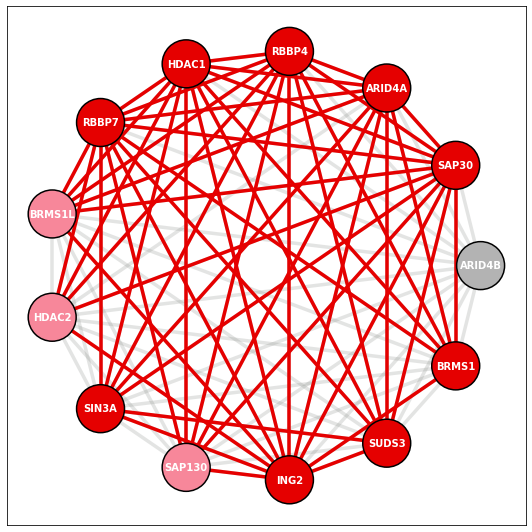

In [22]:
fig, ax = plt.subplots()

bp_PPI_df = getBioPlex('293T', '3.0')
Corum_DF = getCorum('core', 'Human')
ING2_node_layout = display_PPI_network_for_complex(ax, bp_PPI_df, Corum_DF, 2851, 2300, 3.5)

fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_293T_3.0_ING2-complex.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = True)
plt.show()

**Arp2/3** complex from HEK293T cell line PPI data version 3.0

In [23]:
Corum_DF[Corum_DF.ComplexName == 'Arp2/3 protein complex']

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
9,27,Arp2/3 protein complex,Human,ARP2/3 protein complex,None,O15143;O15144;O15145;O15511;P59998;P61158;P61160,10095;10109;10094;10092;10093;10096;10097,MI:0027-cosedimentation;MI:0071-molecular sieving,None,None,None,None,ARC41;ARC34;ARC21;ARC16;ARC20;ARP3;ARP2,None,"Transcript levels of ARP2/3 complex subunits, ...",Homo sapiens (Human);Homo sapiens (Human);Homo...,None,ARPC1B;ARPC2;ARPC3;ARPC5;ARPC4;ACTR3;ACTR2,9359840,Actin-related protein 2/3 complex subunit 1B;A...


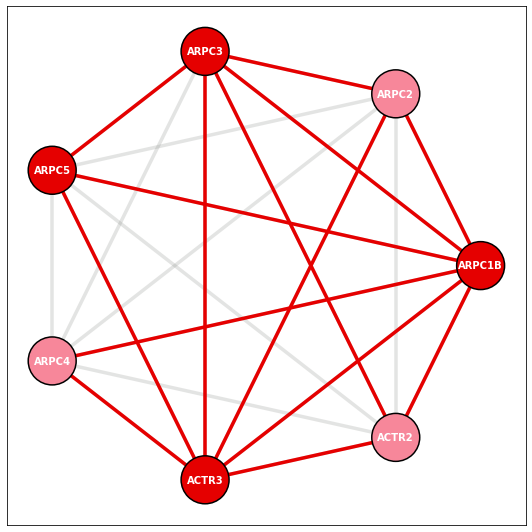

In [24]:
fig, ax = plt.subplots()

bp_PPI_df = getBioPlex('293T', '3.0')
Corum_DF = getCorum('core', 'Human')
Arp23_node_layout = display_PPI_network_for_complex(ax, bp_PPI_df, Corum_DF, 27, 2300, 3.5)

fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_293T_3.0_Arp2-3-complex.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = True)
plt.show()

**COP9 Signalsome** complex from *HCT116 cell line PPI data version 1.0* & *HEK293T cell line PPI data version 3.0*

In [25]:
Corum_DF[Corum_DF.ComplexName == 'COP9 signalosome complex']

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
655,2174,COP9 signalosome complex,Human,"JAB1-containing signalosome (GPS1, COPS2, COPS...",None,P61201;Q13098;Q7L5N1;Q92905;Q99627;Q9BT78;Q9UB...,9318;2873;10980;10987;10920;51138;50813;8533,MI:0047-far western blotting,GO:2001141;GO:0006355;GO:0007165;GO:0009583;GO...,regulation of RNA biosynthetic process;regulat...,11.02.03.04;30;34.11.01,transcriptional control;CELLULAR COMMUNICATION...,"CSN2, TRIP15;COPS1, CSN1;CSN6, HVIP;CSN5, JAB1...","The purified complex is very similar, if not i...",None,Homo sapiens (Human);Homo sapiens (Human);Homo...,"Since the authors did not specify COP7, we use...",COPS2;GPS1;COPS6;COPS5;COPS8;COPS4;COPS7A;COPS3,9535219,COP9 signalosome complex subunit 2;COP9 signal...


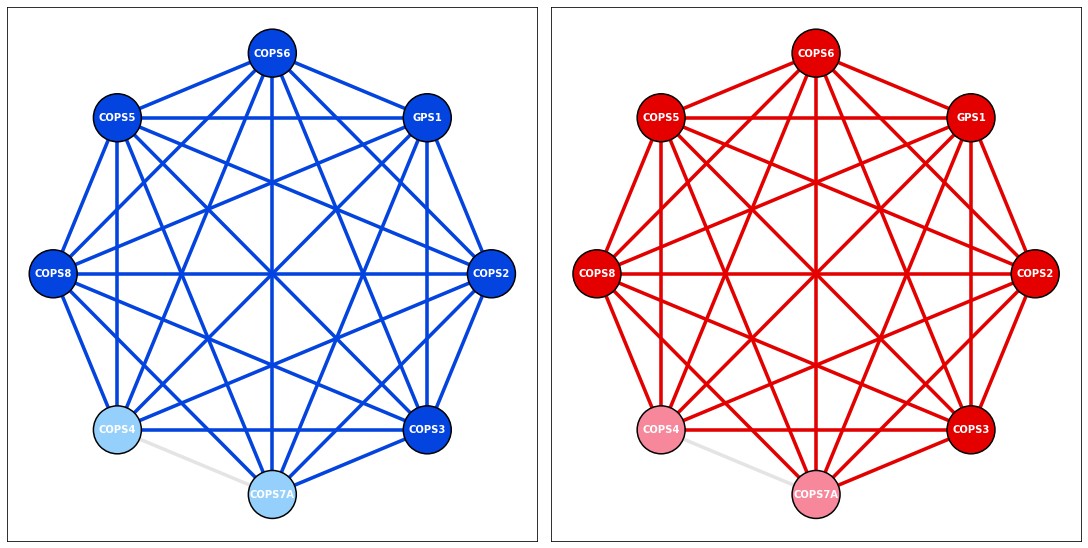

In [26]:
from matplotlib import gridspec

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig) # define 2 columns since we'll have two networks
spec.update(wspace=0.025) # set the spacing between axes.

# pull CORUM complexes we're interested in
Corum_DF = getCorum('core', 'Human')

# HCT116 1.0
ax_HCT116_v1 = fig.add_subplot(spec[0]) # create axes object for HCT116 v1 network
bp_HCT116_v1_PPI_df = getBioPlex('HCT116', '1.0') # load PPI data for HCT116 v1
COP9_node_layout = display_PPI_network_for_complex(ax_HCT116_v1, bp_HCT116_v1_PPI_df, Corum_DF, 2174, 2300, 3.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue')

# HEK293T 3.0
ax_293T_v3 = fig.add_subplot(spec[1]) # create axes object for HEK293T v3 network
bp_293T_v3_df = getBioPlex('293T', '3.0') # load PPI data for HEK293T v3
COP9_node_layout = display_PPI_network_for_complex(ax_293T_v3, bp_293T_v3_df, Corum_DF, 2174, 2300, 3.5, node_pos=COP9_node_layout)

fig = plt.gcf()
fig.set_size_inches(15, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_HCT116_1.0_VS_293T_3.0_COP9-signalsome-complex.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = True)
plt.show()

**Fanconi Anemia Core** complex from *HCT116 cell line PPI data version 1.0* & *HEK293T cell line PPI data version 3.0*

In [27]:
Corum_DF[Corum_DF.ComplexName == 'FA core complex 1 (Fanconi anemia core complex 1)']

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
607,1623,FA core complex 1 (Fanconi anemia core complex 1),Human,None,None,O15287;O15360;Q00597;Q9HB96;Q9NPI8,2189;2175;2176;2178;2188,MI:0027-cosedimentation,GO:0016567;GO:0006974;GO:0005634,protein ubiquitination;cellular response to DN...,14.07.05;32.01.09;70.10,"modification by ubiquitination, deubiquitinati...",XRCC9;FAA FACA FANCH;FAC FACC;FACE;None,FANCE functions to target cytoplasmic FANCC to...,FA complex is involved in Fanconi anemia (FA) ...,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,FANCG;FANCA;FANCC;FANCE;FANCF,12093742,Fanconi anemia group G protein;Fanconi anemia ...


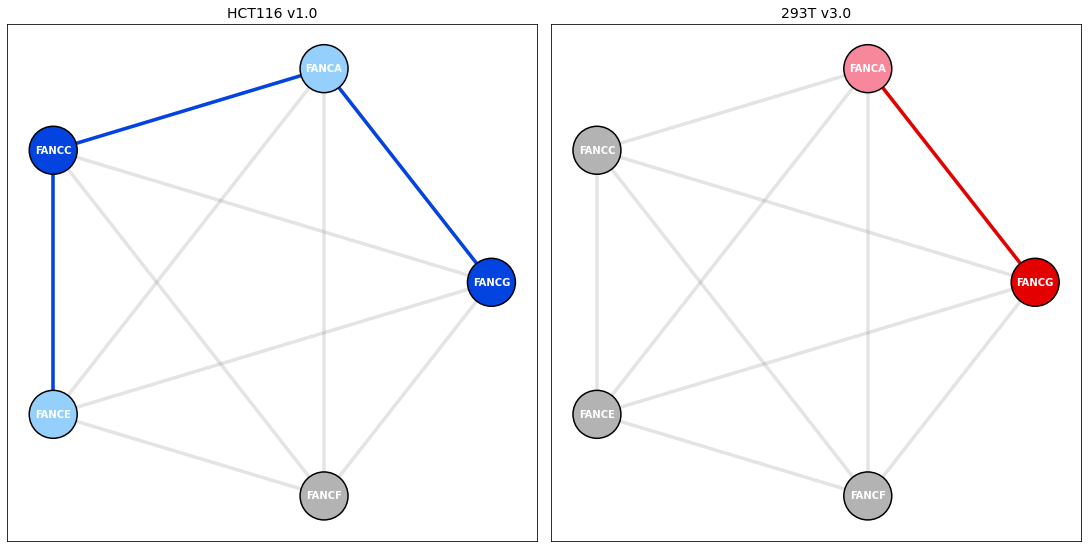

In [28]:
from matplotlib import gridspec

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig) # define 2 columns since we'll have two networks
spec.update(wspace=0.025) # set the spacing between axes.

# pull CORUM complexes we're interested in
Corum_DF = getCorum('core', 'Human')

# HCT116 1.0
ax_HCT116_v1 = fig.add_subplot(spec[0]) # create axes object for HCT116 v1 network
bp_HCT116_v1_PPI_df = getBioPlex('HCT116', '1.0') # load PPI data for HCT116 v1
Fanconi_Anemia_node_layout = display_PPI_network_for_complex(ax_HCT116_v1, bp_HCT116_v1_PPI_df, Corum_DF, 1623, 2300, 3.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue')
ax_HCT116_v1.set_title('HCT116 v1.0', color = 'black', fontsize = 14) # set title

# HEK293T 3.0
ax_293T_v3 = fig.add_subplot(spec[1]) # create axes object for HEK293T v3 network
bp_293T_v3_df = getBioPlex('293T', '3.0') # load PPI data for HEK293T v3
Fanconi_Anemia_node_layout = display_PPI_network_for_complex(ax_293T_v3, bp_293T_v3_df, Corum_DF, 1623, 2300, 3.5, node_pos = Fanconi_Anemia_node_layout)
ax_293T_v3.set_title('293T v3.0', color = 'black', fontsize = 14) # set title

fig = plt.gcf()
fig.set_size_inches(15, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_HCT116_1.0_VS_293T_3.0_Fanconi-Anemia-core-complex.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = True)
plt.show()

### Recreate *Figure 1* from *Cell* 2021 BioPlex 3.0 paper

**Exosome** complex

In [29]:
Corum_DF[Corum_DF.ComplexID == 7443]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
2347,7443,Exosome,Human,None,HeLa cells,Q01780;Q06265;Q13868;Q15024;Q5RKV6;Q8TF46;Q96B...,5394;5393;23404;23016;118460;115752;11340;1020...,MI:0004-affinity chromatography technologies;M...,GO:0004532;GO:0006401;GO:0005737,exoribonuclease activity;RNA catabolic process...,01.03.16.01;70.03,RNA degradation;cytoplasm,PMSCL PMSCL2 RRP6;PMSCL1;RRP4;KIAA0116 RRP42;M...,None,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,EXOSC10;EXOSC9;EXOSC2;EXOSC7;EXOSC6;DIS3L;EXOS...,20531389,Exosome component 10;Exosome complex component...


**BCOR** complex

In [30]:
Corum_DF[Corum_DF.ComplexID == 1178]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
520,1178,BCOR complex,Human,Ubiquitin E3 ligase,None,P11142;P63208;Q06587;Q6W2J9;Q8N488;Q8NHM5;Q994...,3312;6500;6015;54880;23429;84678;6045;84759,MI:0019-coimmunoprecipitation,GO:0016567;GO:0005634;GO:0006511;GO:0016569;GO...,protein ubiquitination;nucleus;ubiquitin-depen...,14.07.05;70.10;14.13.01.01;11,"modification by ubiquitination, deubiquitinati...","HSC70, HSP73, HSPA10;EMC19, OCP2, SKP1A, TCEB1...",Ubiquitin E3 ligases covalently attach ubiquit...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,HSPA8;SKP1;RING1;BCOR;RYBP;KDM2B;RNF2;PCGF1,16943429,Heat shock cognate 71 kDa protein;S-phase kina...


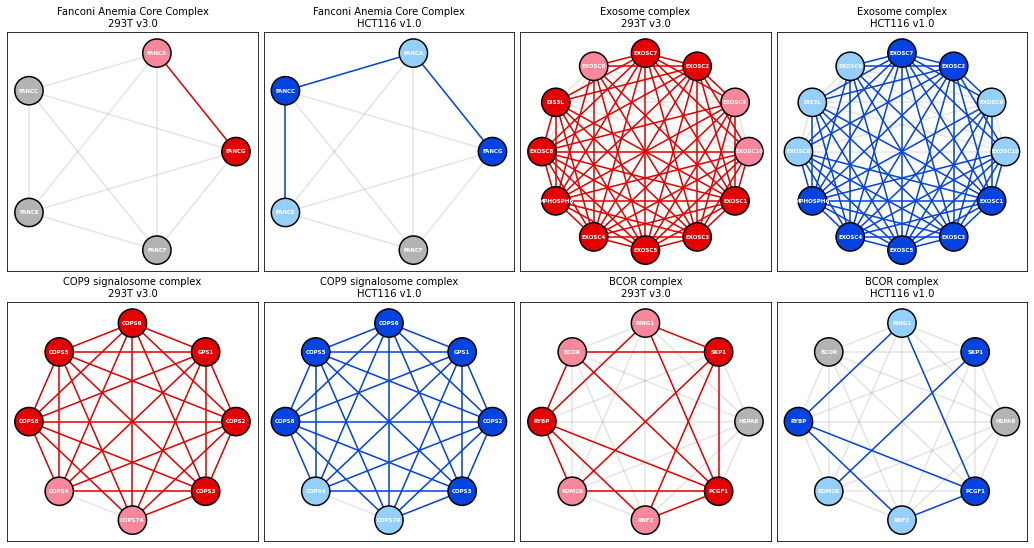

In [31]:
from matplotlib import gridspec

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig) # define 2 columns since we'll have two networks
spec.update(wspace=0.01,hspace=0.01) # set the spacing between axes.

# pull CORUM complexes we're interested in
Corum_DF = getCorum('core', 'Human')

# HEK293T 3.0 - create axes objects for HEK293T v3 network
ax_293T_v3_A = fig.add_subplot(spec[0,0])
ax_293T_v3_C = fig.add_subplot(spec[0,2])
ax_293T_v3_E = fig.add_subplot(spec[1,0])
ax_293T_v3_G = fig.add_subplot(spec[1,2])

bp_293T_v3_df = getBioPlex('293T', '3.0') # load PPI data for HEK293T v3

Fanconi_Anemia_node_layout = display_PPI_network_for_complex(ax_293T_v3_A, bp_293T_v3_df, Corum_DF, 1623, 800, 1.5, node_font_size=5.5)
Exosome_node_layout = display_PPI_network_for_complex(ax_293T_v3_C, bp_293T_v3_df, Corum_DF, 7443, 800, 1.5, node_font_size=5.5)
COP9_node_layout = display_PPI_network_for_complex(ax_293T_v3_E, bp_293T_v3_df, Corum_DF, 2174, 800, 1.5, node_font_size=5.5)
BCOR_node_layout = display_PPI_network_for_complex(ax_293T_v3_G, bp_293T_v3_df, Corum_DF, 1178, 800, 1.5, node_font_size=5.5)

# set titles
ax_293T_v3_A.set_title('Fanconi Anemia Core Complex\n293T v3.0', color = 'black', fontsize = 10)
ax_293T_v3_C.set_title('Exosome complex\n293T v3.0', color = 'black', fontsize = 10)
ax_293T_v3_E.set_title('COP9 signalosome complex\n293T v3.0', color = 'black', fontsize = 10)
ax_293T_v3_G.set_title('BCOR complex\n293T v3.0', color = 'black', fontsize = 10)

# HCT116 1.0 - create axes object for HCT116 v1 network
ax_HCT116_v1_B = fig.add_subplot(spec[0,1])
ax_HCT116_v1_D = fig.add_subplot(spec[0,3])
ax_HCT116_v1_F = fig.add_subplot(spec[1,1])
ax_HCT116_v1_H = fig.add_subplot(spec[1,3])

bp_HCT116_v1_df = getBioPlex('HCT116', '1.0') # load PPI data for HCT116 v1

Fanconi_Anemia_node_layout = display_PPI_network_for_complex(ax_HCT116_v1_B, bp_HCT116_v1_df, Corum_DF, 1623, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue', node_pos=Fanconi_Anemia_node_layout)
Exosome_node_layout = display_PPI_network_for_complex(ax_HCT116_v1_D, bp_HCT116_v1_df, Corum_DF, 7443, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue', node_pos=Exosome_node_layout)
COP9_node_layout = display_PPI_network_for_complex(ax_HCT116_v1_F, bp_HCT116_v1_df, Corum_DF, 2174, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue', node_pos=COP9_node_layout)
BCOR_node_layout = display_PPI_network_for_complex(ax_HCT116_v1_H, bp_HCT116_v1_df, Corum_DF, 1178, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue', node_pos=BCOR_node_layout)

# set titles
ax_HCT116_v1_B.set_title('Fanconi Anemia Core Complex\nHCT116 v1.0', color = 'black', fontsize = 10)
ax_HCT116_v1_D.set_title('Exosome complex\nHCT116 v1.0', color = 'black', fontsize = 10)
ax_HCT116_v1_F.set_title('COP9 signalosome complex\nHCT116 v1.0', color = 'black', fontsize = 10)
ax_HCT116_v1_H.set_title('BCOR complex\nHCT116 v1.0', color = 'black', fontsize = 10)

fig = plt.gcf()
fig.set_size_inches(14.25, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_HCT116_1.0_VS_293T_3.0_Fig1_Cell2021.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = False)
plt.show()

### Recreate *Figure 2* from *Nature* 2017 BioPlex 2.0 paper

**Arp2/3** complex

In [32]:
Corum_DF[Corum_DF.ComplexID == 27]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
9,27,Arp2/3 protein complex,Human,ARP2/3 protein complex,None,O15143;O15144;O15145;O15511;P59998;P61158;P61160,10095;10109;10094;10092;10093;10096;10097,MI:0027-cosedimentation;MI:0071-molecular sieving,None,None,None,None,ARC41;ARC34;ARC21;ARC16;ARC20;ARP3;ARP2,None,"Transcript levels of ARP2/3 complex subunits, ...",Homo sapiens (Human);Homo sapiens (Human);Homo...,None,ARPC1B;ARPC2;ARPC3;ARPC5;ARPC4;ACTR3;ACTR2,9359840,Actin-related protein 2/3 complex subunit 1B;A...


**TFIIH transcription factor** complex

In [33]:
Corum_DF[Corum_DF.ComplexID == 1029]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
430,1029,TFIIH transcription factor complex,Human,None,None,P18074;P19447;P32780;P50613;P51946;P51948;Q138...,2068;2071;2965;1022;902;4331;2966;2967;404672;...,MI:0091-chromatography technologies;MI:0071-mo...,GO:0006281;GO:0007049;GO:0006355;GO:0005634;GO...,DNA repair;cell cycle;regulation of transcript...,10.01.05.01;10.03;11.02.03.04;70.10,DNA repair;cell cycle;transcriptional control;...,"XPD, XPDC;XPB, XPBC;BTF2;CAK, CAK1, CDKN7, MO1...",Transcription factor IIH (TFIIH) is a multisub...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,ERCC2;ERCC3;GTF2H1;CDK7;CCNH;MNAT1;GTF2H2;GTF2...,8692842,TFIIH basal transcription factor complex helic...


**Checkpoint RAD** complex

In [34]:
Corum_DF[Corum_DF.ComplexID == 274]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
116,274,9-1-1-RAD17-RFC complex,Human,RAD17-RFC-9-1-1 checkpoint supercomplex,None,O60671;O60921;O75943;P35249;P35250;P40937;P409...,5810;3364;5884;5984;5982;5985;5983;5883,MI:0004-affinity chromatography technologies;M...,None,None,None,None,REC1;None;R24L;None;None;None;None;None,"Rad17-RFC complex binds to nicked circular, ga...",None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,RAD1;HUS1;RAD17;RFC4;RFC2;RFC5;RFC3;RAD9A,12578958,Cell cycle checkpoint protein RAD1;Checkpoint ...


**Nau4/Tip60-HAT** complex B

In [35]:
Corum_DF[Corum_DF.ComplexID == 787]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name syn),Complex comment,Disease comment,SWISSPROT organism,Subunits comment,subunits(Gene name),PubMed ID,subunits(Protein name)
338,787,NuA4/Tip60-HAT complex B,Human,None,None,O96019;Q92993;Q9H2F5;Q9NPF5;Q9UBU8;Q9Y230;Q9Y2...,86;10524;80314;55929;10933;10856;8607;8295,MI:0007-anti tag coimmunoprecipitation,GO:0051276;GO:0006281;GO:0006265;GO:0003677;GO...,chromosome organization;DNA repair;DNA topolog...,42.10.03;10.01.05.01;10.01.09.05;16.03.01;32.0...,organization of chromosome structure;DNA repai...,"BAF53, BAF53A, INO80K;HTATIP, TIP60;None;KIAA1...",The NuA4 histone acetyltransferase (HAT) multi...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,None,ACTL6A;KAT5;EPC1;DMAP1;MORF4L1;RUVBL2;RUVBL1;T...,14966270,Actin-like protein 6A;Histone acetyltransferas...


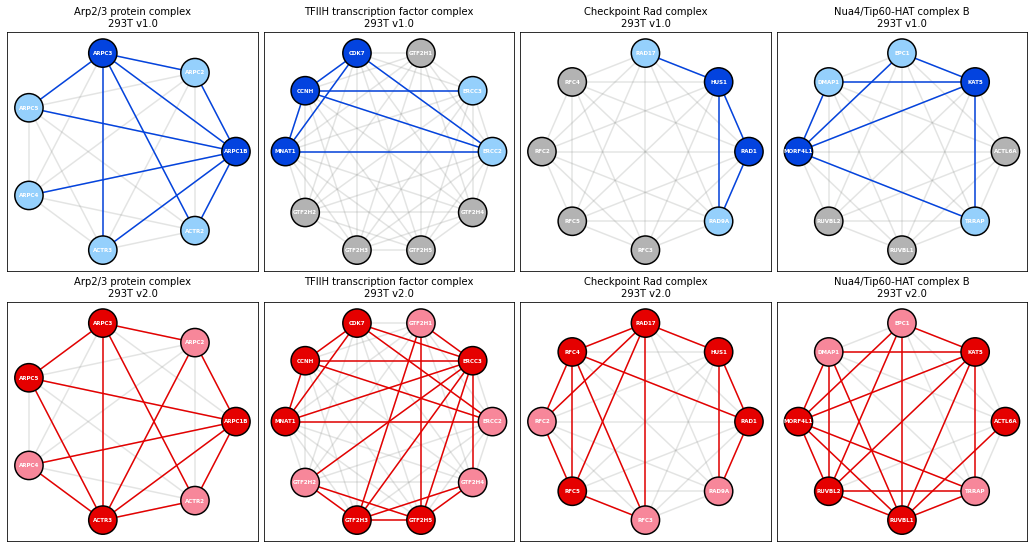

In [36]:
from matplotlib import gridspec

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig) # define 2 columns since we'll have two networks
spec.update(wspace=0.01,hspace=0.01) # set the spacing between axes.

# pull CORUM complexes we're interested in
Corum_DF = getCorum('core', 'Human')

# HEK293T 1.0 - create axes objects for HEK293T v1 network
ax_293T_v1_A = fig.add_subplot(spec[0,0])
ax_293T_v1_B = fig.add_subplot(spec[0,1])
ax_293T_v1_C = fig.add_subplot(spec[0,2])
ax_293T_v1_D = fig.add_subplot(spec[0,3])

bp_293T_v1_df = getBioPlex('293T', '1.0') # load PPI data for HEK293T v1

Arp23_node_layout = display_PPI_network_for_complex(ax_293T_v1_A, bp_293T_v1_df, Corum_DF, 27, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue')
TFIIH_node_layout = display_PPI_network_for_complex(ax_293T_v1_B, bp_293T_v1_df, Corum_DF, 1029, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue')
RAD_node_layout = display_PPI_network_for_complex(ax_293T_v1_C, bp_293T_v1_df, Corum_DF, 274, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue')
NuA4_Tip60_node_layout = display_PPI_network_for_complex(ax_293T_v1_D, bp_293T_v1_df, Corum_DF, 787, 800, 1.5, node_font_size=5.5, bait_node_color='xkcd:blue', prey_node_color='xkcd:light blue', AP_MS_edge_color='xkcd:blue')

# set titles
ax_293T_v1_A.set_title('Arp2/3 protein complex\n293T v1.0', color = 'black', fontsize = 10)
ax_293T_v1_B.set_title('TFIIH transcription factor complex\n293T v1.0', color = 'black', fontsize = 10)
ax_293T_v1_C.set_title('Checkpoint Rad complex\n293T v1.0', color = 'black', fontsize = 10)
ax_293T_v1_D.set_title('Nua4/Tip60-HAT complex B\n293T v1.0', color = 'black', fontsize = 10)

# HEK293T 2.0 - create axes objects for HEK293T v2 network
ax_293T_v2_E = fig.add_subplot(spec[1,0])
ax_293T_v2_F = fig.add_subplot(spec[1,1])
ax_293T_v2_G = fig.add_subplot(spec[1,2])
ax_293T_v2_H = fig.add_subplot(spec[1,3])

bp_293T_v2_df = getBioPlex('293T', '2.0') # load PPI data for HEK293T v2

Arp23_node_layout = display_PPI_network_for_complex(ax_293T_v2_E, bp_293T_v2_df, Corum_DF, 27, 800, 1.5, node_font_size=5.5, node_pos=Arp23_node_layout)
TFIIH_node_layout = display_PPI_network_for_complex(ax_293T_v2_F, bp_293T_v2_df, Corum_DF, 1029, 800, 1.5, node_font_size=5.5, node_pos=TFIIH_node_layout)
RAD_node_layout = display_PPI_network_for_complex(ax_293T_v2_G, bp_293T_v2_df, Corum_DF, 274, 800, 1.5, node_font_size=5.5, node_pos=RAD_node_layout)
NuA4_Tip60_node_layout = display_PPI_network_for_complex(ax_293T_v2_H, bp_293T_v2_df, Corum_DF, 787, 800, 1.5, node_font_size=5.5,node_pos=NuA4_Tip60_node_layout)

# set titles
ax_293T_v2_E.set_title('Arp2/3 protein complex\n293T v2.0', color = 'black', fontsize = 10)
ax_293T_v2_F.set_title('TFIIH transcription factor complex\n293T v2.0', color = 'black', fontsize = 10)
ax_293T_v2_G.set_title('Checkpoint Rad complex\n293T v2.0', color = 'black', fontsize = 10)
ax_293T_v2_H.set_title('Nua4/Tip60-HAT complex B\n293T v2.0', color = 'black', fontsize = 10)

fig = plt.gcf()
fig.set_size_inches(14.25, 7.5)
fig.tight_layout()

# save figure as PNG
fig_out_path = '/n/shared_db/ccb/bioplex/BioPlexPy_testing/figures/network_293T_1.0_VS_293T_2.0_Fig2_Nature2017.png'
plt.savefig(fig_out_path, bbox_inches='tight', dpi = 300 , transparent = False)
plt.show()